<a href="https://colab.research.google.com/github/kutaydemiralay/Sequential-Convex-Programming-for-a-3DOF-Rocket-Landing-Problem/blob/main/Kutay_Demiralay_3DOF_Rocket_Landing_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sequential Convexification Programmig Algorithm**

Converged after 8 iterations.


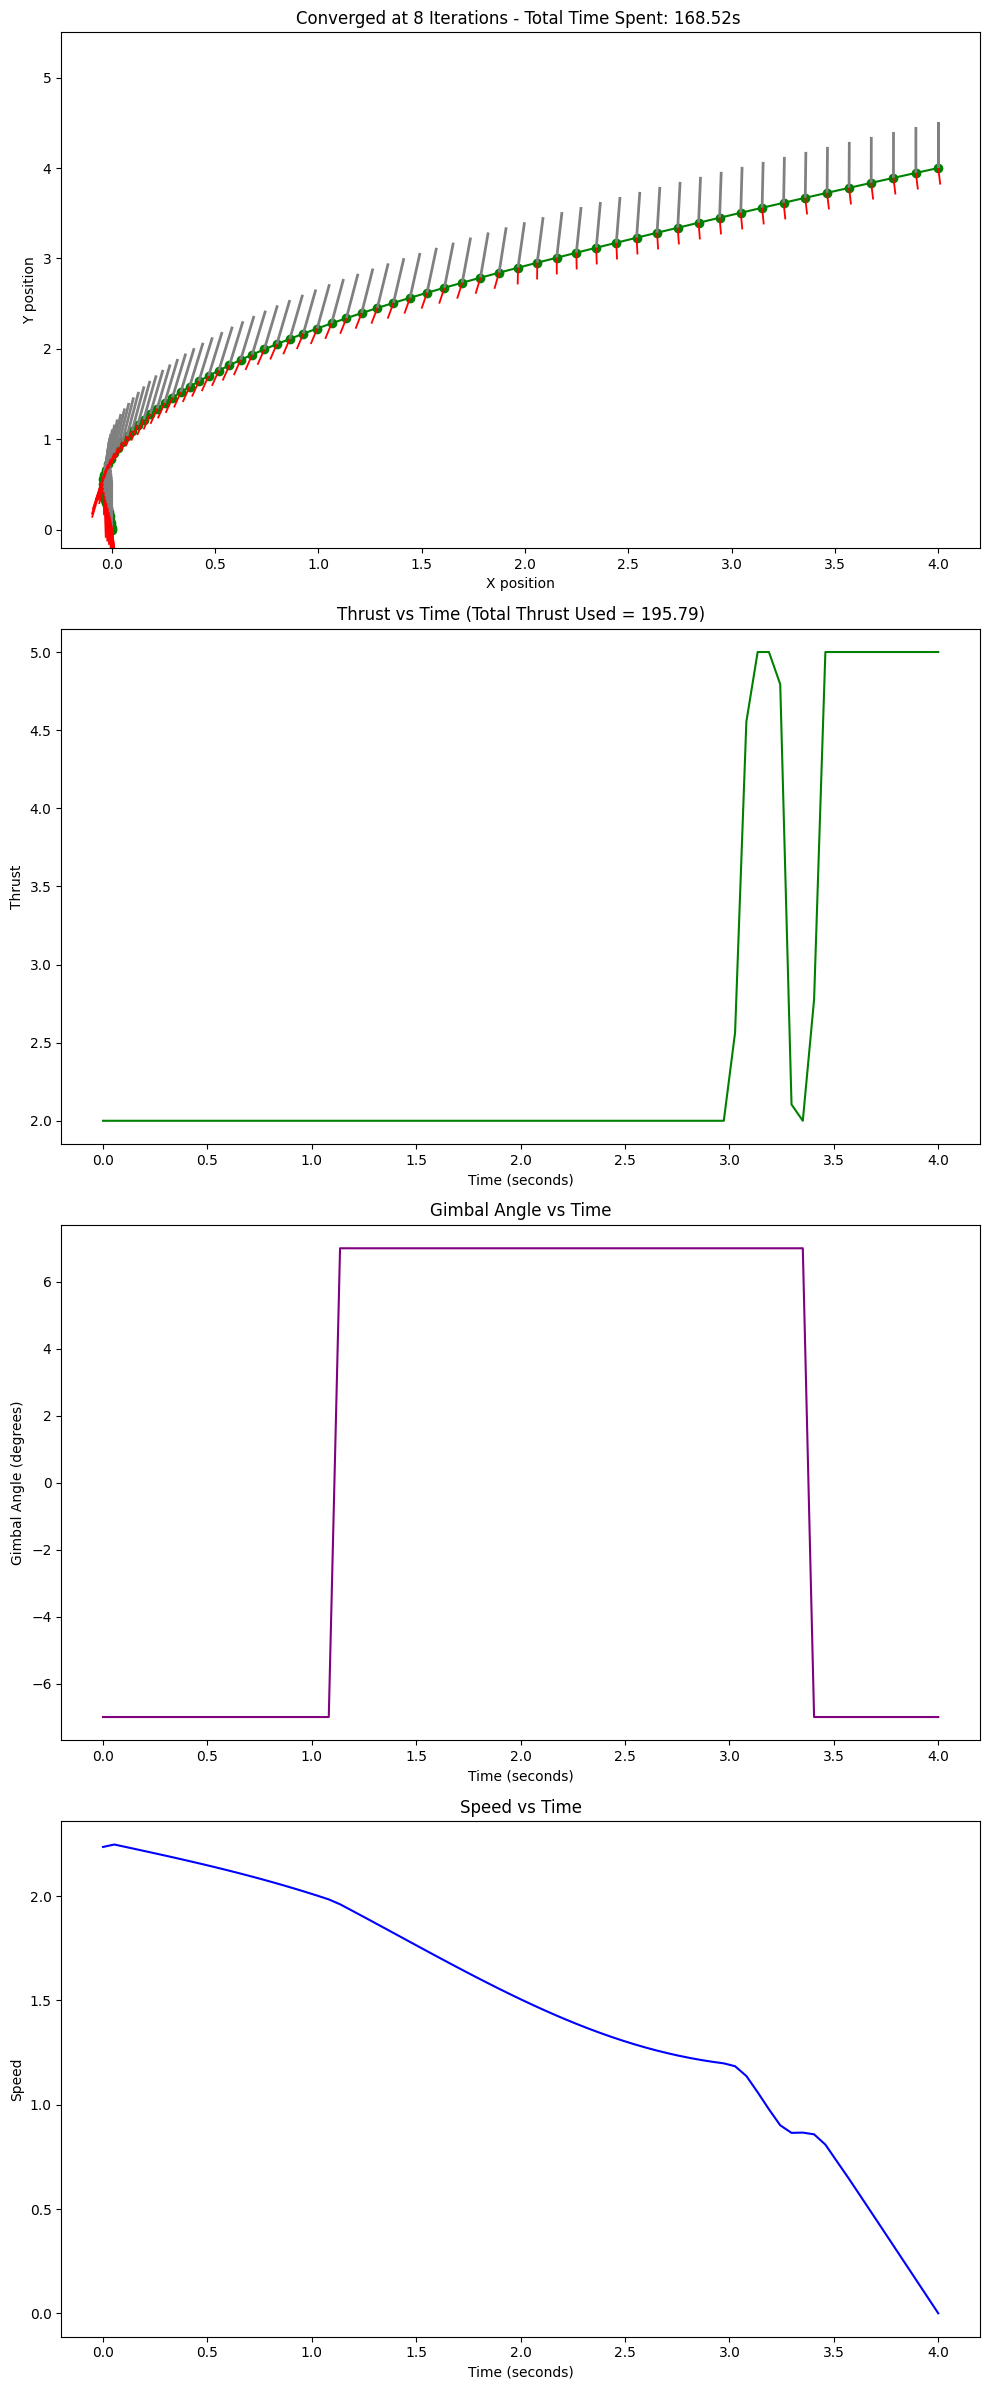

Total thrust used in all time steps: 195.79
Final state: [ 1.07067156e-10  1.19236550e-10 -2.83501389e-10 -6.80933814e-11
  1.11674604e-10 -7.44780572e-11]


In [ ]:
import numpy as np
import cvxpy as cvx
import sympy as sp
from time import time
import matplotlib.pyplot as plt

# Number of trajectory points
K = 75

# Max solver iterations
DEFAULT_MAX_ITERS = 200

# Solver selection
solver = 'ECOS'

# Weight for virtual control
w_nu = 1e5

# Initial trust region radius
tr_radius = 5

# Trust region parameters
rho_0 = 0.0  #Lower bound for thrust region adaptation
rho_1 = 0.25 #Lower threshold for increasing thrust region size
rho_2 = 0.9  #Lower threshold for increasing thrust region size
alpha = 2.0  #Adaptation factor for decreasing thrust region size
beta = 3.2   #Adaptation factor for decreasing thrust region size

# Penalty parameters
penalty_small = 1e3
penalty_large = 1e3
tr_min = 0.1
tr_max = 10.0

# Define the 2D rocket landing problem
n_x = 6  # Number of state variables: [rx, ry, vx, vy, theta, omega]
n_u = 2  # Number of control inputs: [gimbal angle, thrust]

# Rocket parameters
m = 2   # wet mass
I = 1e-2 # moment of inertia (kg*m^2)
r_TB = 1e-2 # distance from thrust center to COM (m)
g = 1 # gravitational acceleration
alphamass=0.1 #mass depletion rate

# Initial and final states
position_init = [4., 4.] # initial Position
velocity_init = [-2., -1.] # initial Velocity
angle_init = [np.deg2rad(0.)] #initial angle
w_init = [np.deg2rad(0.)] #initial angular velocity

final_time_desired = 4  # seconds

position_final = [0., 0.]
velocity_final = [0., 0.]
angle_final = [np.deg2rad(0.)]
w_final = [np.deg2rad(0.)]

# Constraints
t_max = np.deg2rad(60) #maximum angle deviation from prependicular rocket
w_max = np.deg2rad(60) #maximum anglular
max_gimbal = np.deg2rad(7) #max gimbal angle
T_max = 5 #Maximum Thrust
T_min = 2 #Minimum Thrust


# Scaling factors for nondimensionalization
r_scale = np.linalg.norm(position_init)
m_scale = m

# Initial and final states in vector form
x_init = np.concatenate((position_init, velocity_init, angle_init, w_init))
x_final = np.concatenate((position_final, velocity_final, angle_final, w_final))


def mass_depletion_rate(T_B):
    global alphamass
    return -alphamass * np.linalg.norm(T_B)

def redim(var, is_control=False):
    # Scale up a state or control vector
    if is_control:
        var[1, :] *= m_scale * r_scale
    else:
        var[0:4] *= r_scale
    return var

def nondimensionalize():
    # Scale down the parameters and states to make the problem easier to solve numerically
    global  position_init, velocity_init , r_TB, g, I, m, T_min, T_max, x_init, x_final, r_scale
    position_init /= r_scale
    velocity_init /= r_scale
    r_TB /= r_scale
    g /= r_scale
    I /= m_scale * r_scale ** 2
    m /= m_scale
    T_min /= m_scale * r_scale
    T_max /= m_scale * r_scale
    x_init[0:4] /= r_scale
    x_final[0:4] /= r_scale


def functions():
    # Define the dynamics equations and their Jacobians for linearization

    x = sp.Matrix(sp.symbols('rx ry vx vy t w', real=True))
    u = sp.Matrix(sp.symbols('gimbal T', real=True))

    f = sp.Matrix([
        x[2, 0],
        x[3, 0],
        1 / m * sp.sin(x[4, 0] + u[0, 0]) * u[1, 0],
        1 / m * (sp.cos(x[4, 0] + u[0, 0]) * u[1, 0] - m * g),
        x[5, 0],
        1 / I * (-sp.sin(u[0, 0]) * u[1, 0] * r_TB)
    ])

    A = f.jacobian(x)
    B = f.jacobian(u)

    f = sp.lambdify((x, u), f, 'numpy')
    A = sp.lambdify((x, u), A, 'numpy')
    B = sp.lambdify((x, u), B, 'numpy')

    return f, A, B #Functions

def initialization(X, U):
    global K, x_final, x_init, T_max, T_min
    # Set up the initial guess for the trajectory
    U[0, :] = 0
    U[1, :] = (T_max - T_min) / 2

    for k in range(K):
        X[:, k] = ((K - k) / K) * x_init + (k / K) * x_final

    return X, U

def get_constraints(X_v, U_v, X_last_p, U_last_p):
    # Define the constraints for the optimization problem
    constraints = [
        # Boundary conditions:
        X_v[0:2, 0] == x_init[0:2],  # Initial position
        X_v[2:4, 0] == x_init[2:4],  # Initial velocity
        X_v[4, 0] == x_init[4],      # Initial angle
        X_v[5, 0] == x_init[5],      # Initial angular velocity
        X_v[:, -1] == x_final,       # Final state

        # State constraints:
        cvx.abs(X_v[4, :]) <= t_max,  # Maximum angle
        cvx.abs(X_v[5, :]) <= w_max,  # Maximum angular velocity
        X_v[1, :] >= 0,              # Ensure vertical position is non-negative

        # Control constraints:
        cvx.abs(U_v[0, :]) <= max_gimbal,  # Maximum gimbal angle
        U_v[1, :] >= T_min,                # Minimum thrust
        U_v[1, :] <= T_max,                # Maximum thrust
    ]
    return constraints

def rk4(func, y0, tf, steps, *args):
    # Runge-Kutta 4th order integration method for numerical integration
    t = np.linspace(0, tf, steps)
    y0 = y0.reshape(-1, 1)
    y = np.zeros((len(t), len(y0)))
    y[0, :] = y0.flatten()

    for i in range(len(t) - 1):
        h = t[i + 1] - t[i]
        k1 = h * func(y[i], t[i], *args)
        k2 = h * func(y[i] + 0.5 * k1, t[i] + 0.5 * h, *args)
        k3 = h * func(y[i] + 0.5 * k2, t[i] + 0.5 * h, *args)
        k4 = h * func(y[i] + k3, t[i] + h, *args)
        y[i + 1, :] = y[i, :] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return y


def derivaritve_ode(V, t, u_t0, u_t1):
    # Compute the derivative of V for the ODE
    global A_bar_ind, B_bar_ind, C_bar_ind, z_bar_ind, dt, f, A, B, V0, A_bar, B_bar, C_bar, z_bar
    alpha = (dt - t) / dt
    beta = t / dt
    x = V[x_ind]
    u = u_t0 + (t / dt) * (u_t1 - u_t0)
    Phi_A_xi = np.linalg.inv(V[A_bar_ind].reshape((n_x, n_x)))
    A_subs = A(x, u)
    B_subs = B(x, u)
    f_subs = f(x, u)
    dV = np.zeros_like(V)
    dV[x_ind] = f_subs.T
    dV[A_bar_ind] = np.matmul(A_subs, V[A_bar_ind].reshape((n_x, n_x))).reshape(-1)
    dV[B_bar_ind] = np.matmul(Phi_A_xi, B_subs).reshape(-1) * alpha
    dV[C_bar_ind] = np.matmul(Phi_A_xi, B_subs).reshape(-1) * beta
    z_t = np.squeeze(f_subs) - np.matmul(A_subs, x) - np.matmul(B_subs, u)
    dV[z_bar_ind] = np.matmul(Phi_A_xi, z_t)
    return dV


def derivative_state(x, t, u_t0, u_t1):
    # Compute the state derivative
    u = u_t0 + (t / dt) * (u_t1 - u_t0)
    return np.squeeze(f(x, u))


def discretization(X, U):
    # Calculate the discretization for the given states and inputs
    global A_bar_ind, B_bar_ind, C_bar_ind, z_bar_ind, dt, f, A, B, V0, A_bar, B_bar, C_bar, z_bar, x_ind
    for k in range(K - 1):
        V0[x_ind] = X[:, k].flatten()
        V = rk4(derivaritve_ode, V0, dt, 2, U[:, k], U[:, k + 1])[1, :]
        Phi = V[A_bar_ind].reshape((n_x, n_x))
        A_bar[:, k] = Phi.flatten(order='F')
        B_bar[:, k] = np.matmul(Phi, V[B_bar_ind].reshape((n_x, n_u))).flatten(order='F')
        C_bar[:, k] = np.matmul(Phi, V[C_bar_ind].reshape((n_x, n_u))).flatten(order='F')
        z_bar[:, k] = np.matmul(Phi, V[z_bar_ind])

    return A_bar, B_bar, C_bar, z_bar

def integrate_nonlinear_piecewise(X_l, U):
    # Integrate the nonlinear dynamics piecewise
    global dt
    X_nl = np.zeros_like(X_l)
    X_nl[:, 0] = X_l[:, 0]
    for k in range(K - 1):
        X_nl[:, k + 1] = rk4(derivative_state, X_l[:, k], dt, 2, U[:, k], U[:, k + 1])[1, :]
    return X_nl

def FOH_init(m, K, final_time_desired):
    # Initialize the first-order hold for the control inputs
    A_bar = np.zeros([n_x * n_x, K - 1])
    B_bar = np.zeros([n_x * n_u, K - 1])
    C_bar = np.zeros([n_x * n_u, K - 1])
    z_bar = np.zeros([n_x, K - 1])

    x_end = n_x
    A_bar_end = n_x * (1 + n_x)
    B_bar_end = n_x * (1 + n_x + n_u)
    C_bar_end = n_x * (1 + n_x + n_u + n_u)
    z_bar_end = n_x * (1 + n_x + n_u + n_u + 1)
    x_ind = slice(0, x_end)
    A_bar_ind = slice(x_end, A_bar_end)
    B_bar_ind = slice(A_bar_end, B_bar_end)
    C_bar_ind = slice(B_bar_end, C_bar_end)
    z_bar_ind = slice(C_bar_end, z_bar_end)

    f, A, B = functions()

    V0 = np.zeros((n_x * (1 + n_x + n_u + n_u + 1),))
    V0[A_bar_ind] = np.eye(n_x).reshape(-1)

    dt = 1. / (K - 1) * final_time_desired

    return A_bar_ind, B_bar_ind, C_bar_ind, z_bar_ind, dt, f, A, B, V0, A_bar, B_bar, C_bar, z_bar, x_ind

def model_init(m, K):
    # Initialize the optimization model
    global n_x, n_u, A_bar, B_bar, C_bar, z_bar
    X = cvx.Variable((n_x, K))
    U = cvx.Variable((n_u, K))
    nu = cvx.Variable((n_x, K - 1)) #Virtual control, helps relaxation and feasibility

    A_bar_param = cvx.Parameter((n_x * n_x, K - 1))
    B_bar_param = cvx.Parameter((n_x * n_u, K - 1))
    C_bar_param = cvx.Parameter((n_x * n_u, K - 1))
    z_bar_param = cvx.Parameter((n_x, K - 1))
    X_last_param = cvx.Parameter((n_x, K))
    U_last_param = cvx.Parameter((n_u, K))
    weight_nu_param = cvx.Parameter(nonneg=True)
    tr_radius_param = cvx.Parameter(nonneg=True)

    constraints = get_constraints(X, U, X_last_param, U_last_param)

    for k in range(K - 1):
        constraint = (
            X[:, k + 1] == (
                cvx.reshape(A_bar_param[:, k], (n_x, n_x)) @ X[:, k] +
                cvx.reshape(B_bar_param[:, k], (n_x, n_u)) @ U[:, k] +
                cvx.reshape(C_bar_param[:, k], (n_x, n_u)) @ U[:, k + 1] +
                z_bar_param[:, k] +
                nu[:, k]
            )
        )
        constraints.append(constraint)

    du = U - U_last_param
    dx = X - X_last_param
    constraints += [cvx.norm(dx, 1) + cvx.norm(du, 1) <= tr_radius_param]

    # Penalties for trust region size
    penalty_small_tr = penalty_small * cvx.pos(tr_min - tr_radius_param)
    penalty_large_tr = penalty_large * cvx.pos(tr_radius_param - tr_max)

    sc_objective = cvx.Minimize(weight_nu_param * cvx.norm(nu, 1) + penalty_small_tr + penalty_large_tr)


    return A_bar_param, B_bar_param, C_bar_param, z_bar_param, X_last_param, U_last_param, weight_nu_param, tr_radius_param, X, U, nu, sc_objective, constraints

def set_parameter(A_bar_param, B_bar_param, C_bar_param, z_bar_param, X_last_param, U_last_param, weight_nu_param, tr_radius_param, A_bar, B_bar, C_bar, z_bar, X_last, U_last, weight_nu, tr_radius):
    # Set the parameter values for the optimization problem
    A_bar_param.value = A_bar
    B_bar_param.value = B_bar
    C_bar_param.value = C_bar
    z_bar_param.value = z_bar
    X_last_param.value = X_last
    U_last_param.value = U_last
    weight_nu_param.value = weight_nu
    tr_radius_param.value = tr_radius


def solve(sc_objective, constraints, verbose=False, solver='ECOS', max_iters=DEFAULT_MAX_ITERS):
    # Solve the optimization problem
    prob = cvx.Problem(sc_objective, constraints)
    try:
        result = prob.solve(verbose=verbose, solver=solver, max_iters=max_iters)
        solved = True
        return solved
    except cvx.SolverError as e:
        return False

nondimensionalize()


# state and input initialization
states, controls = initialization(np.empty(shape=[n_x, K]),np.empty(shape=[n_u, K]) )

all_state = [redim(np.copy(states))]
all_control = [redim(np.copy(controls), is_control=True)]

A_bar_ind, B_bar_ind, C_bar_ind, z_bar_ind, dt, f, A, B, V0, A_bar, B_bar, C_bar, z_bar, x_ind = FOH_init(m, K, final_time_desired)
A_bar_param, B_bar_param, C_bar_param, z_bar_param, X_last_param, U_last_param, weight_nu_param, tr_radius_param, X, U, nu, sc_objective, constraints = model_init(m, K)

last_nonlinear_cost = None
converged = False

t0_total = time()

for it in range(DEFAULT_MAX_ITERS):


    A_bar, B_bar, C_bar, z_bar = discretization(states, controls)

    set_parameter(A_bar_param, B_bar_param, C_bar_param, z_bar_param, X_last_param, U_last_param, weight_nu_param, tr_radius_param, A_bar, B_bar, C_bar, z_bar, states, controls, w_nu, tr_radius)

    max_inner_iterations = 500  # Set a reasonable limit for inner iterations

    for inner_it in range(max_inner_iterations):

        solved = solve(sc_objective, constraints, verbose=False, solver=solver, max_iters=DEFAULT_MAX_ITERS)

        new_state, new_control = X.value, U.value

        X_nl = integrate_nonlinear_piecewise(new_state, new_control)

        linear_cost_dynamics = np.linalg.norm(nu.value, 1)
        nonlinear_cost_dynamics = np.linalg.norm(new_state - X_nl, 1)

        linear_cost_constraints = nonlinear_cost_constraints = 0  # Linear, Nonlinear Cost function placeholders

        linear_cost = linear_cost_dynamics + linear_cost_constraints
        nonlinear_cost = nonlinear_cost_dynamics + nonlinear_cost_constraints

        if last_nonlinear_cost is None:
            last_nonlinear_cost = nonlinear_cost
            states = new_state
            controls = new_control
            break

        actual_change = last_nonlinear_cost - nonlinear_cost
        pred_change = last_nonlinear_cost - linear_cost

        #Adaptive Step Size
        if abs(pred_change) < 1e-6:
            converged = True
            break
        else:
            rho = actual_change / pred_change
            if rho < rho_0:
                tr_radius /= alpha

            else:
                states, controls = new_state, new_control

                if rho < rho_1:

                    tr_radius /= alpha
                elif rho >= rho_2:

                    tr_radius *= beta

                last_nonlinear_cost = nonlinear_cost
                break

        params = { 'tr_radius': tr_radius}
        set_parameter(A_bar_param, B_bar_param, C_bar_param, z_bar_param, X_last_param, U_last_param, weight_nu_param, tr_radius_param, A_bar, B_bar, C_bar, z_bar, states, controls, w_nu, tr_radius)


    all_state.append(redim(states.copy()))
    all_control.append(redim(controls.copy(), is_control=True))

    if converged:
        print(f'Converged after {it + 1} iterations.')
        break

total_time = time() - t0_total

if not converged:
    print('Default maximum number of iterations reached without convergence.')

all_state = np.stack(all_state)
all_control = np.stack(all_control)



# Calculate the total thrust used
total_thrust = np.sum(all_control[-1][1, :])


# Vector scaling
attitude_scale = 20
thrust_scale = 110

def my_plot(fig, figures_i, total_time, total_thrust):
    global r_init, final_time_desired, K
    ax1 = fig.add_subplot(411)
    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)

    X_i = all_state[figures_i, :, :]
    U_i = all_control[figures_i, :, :]
    K = X_i.shape[1]
    time_in_sec = np.linspace(0, final_time_desired, K)

    # Position plot
    ax1.set_xlabel('X position')
    ax1.set_ylabel('Y position')
    ax1.plot(X_i[0, :], X_i[1, :], color='green', zorder=0)
    ax1.scatter(X_i[0, :], X_i[1, :], color='green', zorder=1)  # Adding dots at each iteration point
    rx, ry = X_i[0, :], X_i[1, :]
    dx, dy = np.sin(X_i[4, :]), np.cos(X_i[4, :])
    Fx, Fy = -np.sin(X_i[4, :] + U_i[0, :]) * U_i[1, :], -np.cos(X_i[4, :] + U_i[0, :]) * U_i[1, :]
    ax1.quiver(rx, ry, dx, dy, color='grey', width=0.003, scale=attitude_scale, headwidth=1, headlength=0)
    ax1.quiver(rx, ry, Fx, Fy, color='red', width=0.002, scale=thrust_scale, headwidth=1, headlength=0)
    ax1.set_title(f"Converged at {figures_i} Iterations - Total Time Spent: {total_time:.2f}s ")
    ax1.set_ylim([None, np.max(X_i[1, :]) + 1.5])

    # Thrust plot
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Thrust')
    ax2.plot(time_in_sec, U_i[1, :], color='green')
    ax2.set_title(f"Thrust vs Time (Total Thrust Used = {total_thrust:.2f})")

    # Gimbal angle plot
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Gimbal Angle (degrees)')
    gimbal_angles_deg = np.rad2deg(U_i[0, :])
    ax3.plot(time_in_sec, gimbal_angles_deg, color='purple')
    ax3.set_title("Gimbal Angle vs Time")

    # Speed plot
    speed = np.sqrt(X_i[2, :]**2 + X_i[3, :]**2)
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Speed')
    ax4.plot(time_in_sec, speed, color='blue')
    ax4.set_title("Speed vs Time")

    fig.tight_layout()

def plot(X_in, U_in, total_time):
    global figures_i, figures_N, all_state, all_control
    figures_N = X_in.shape[0]
    figures_i = figures_N - 1
    all_state, all_control = X_in, U_in
    fig = plt.figure(figsize=(10, 24))
    my_plot(fig, figures_i, total_time, total_thrust)
    plt.show()

# Plot the Final Results
plot(all_state, all_control, total_time)

print(f"Total thrust used in all time steps: {total_thrust:.2f}")
print(f"Final state: {all_state[-1][:, -1]}")



**General Nonlinear Optimizer Algorithm**

<ipython-input-2-93ca6eaf3927>:115: OptimizeWarning: Unknown solver options: tol
  result = scipy.optimize.minimize(cost,
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 693.4625981499853
            Iterations: 37
            Function evaluations: 20239
            Gradient evaluations: 33
Final State:
[ 2.09382402e-15  2.35732681e-16  1.01866196e-15  2.32451722e-15
 -4.97355385e-16 -4.68133573e-16]


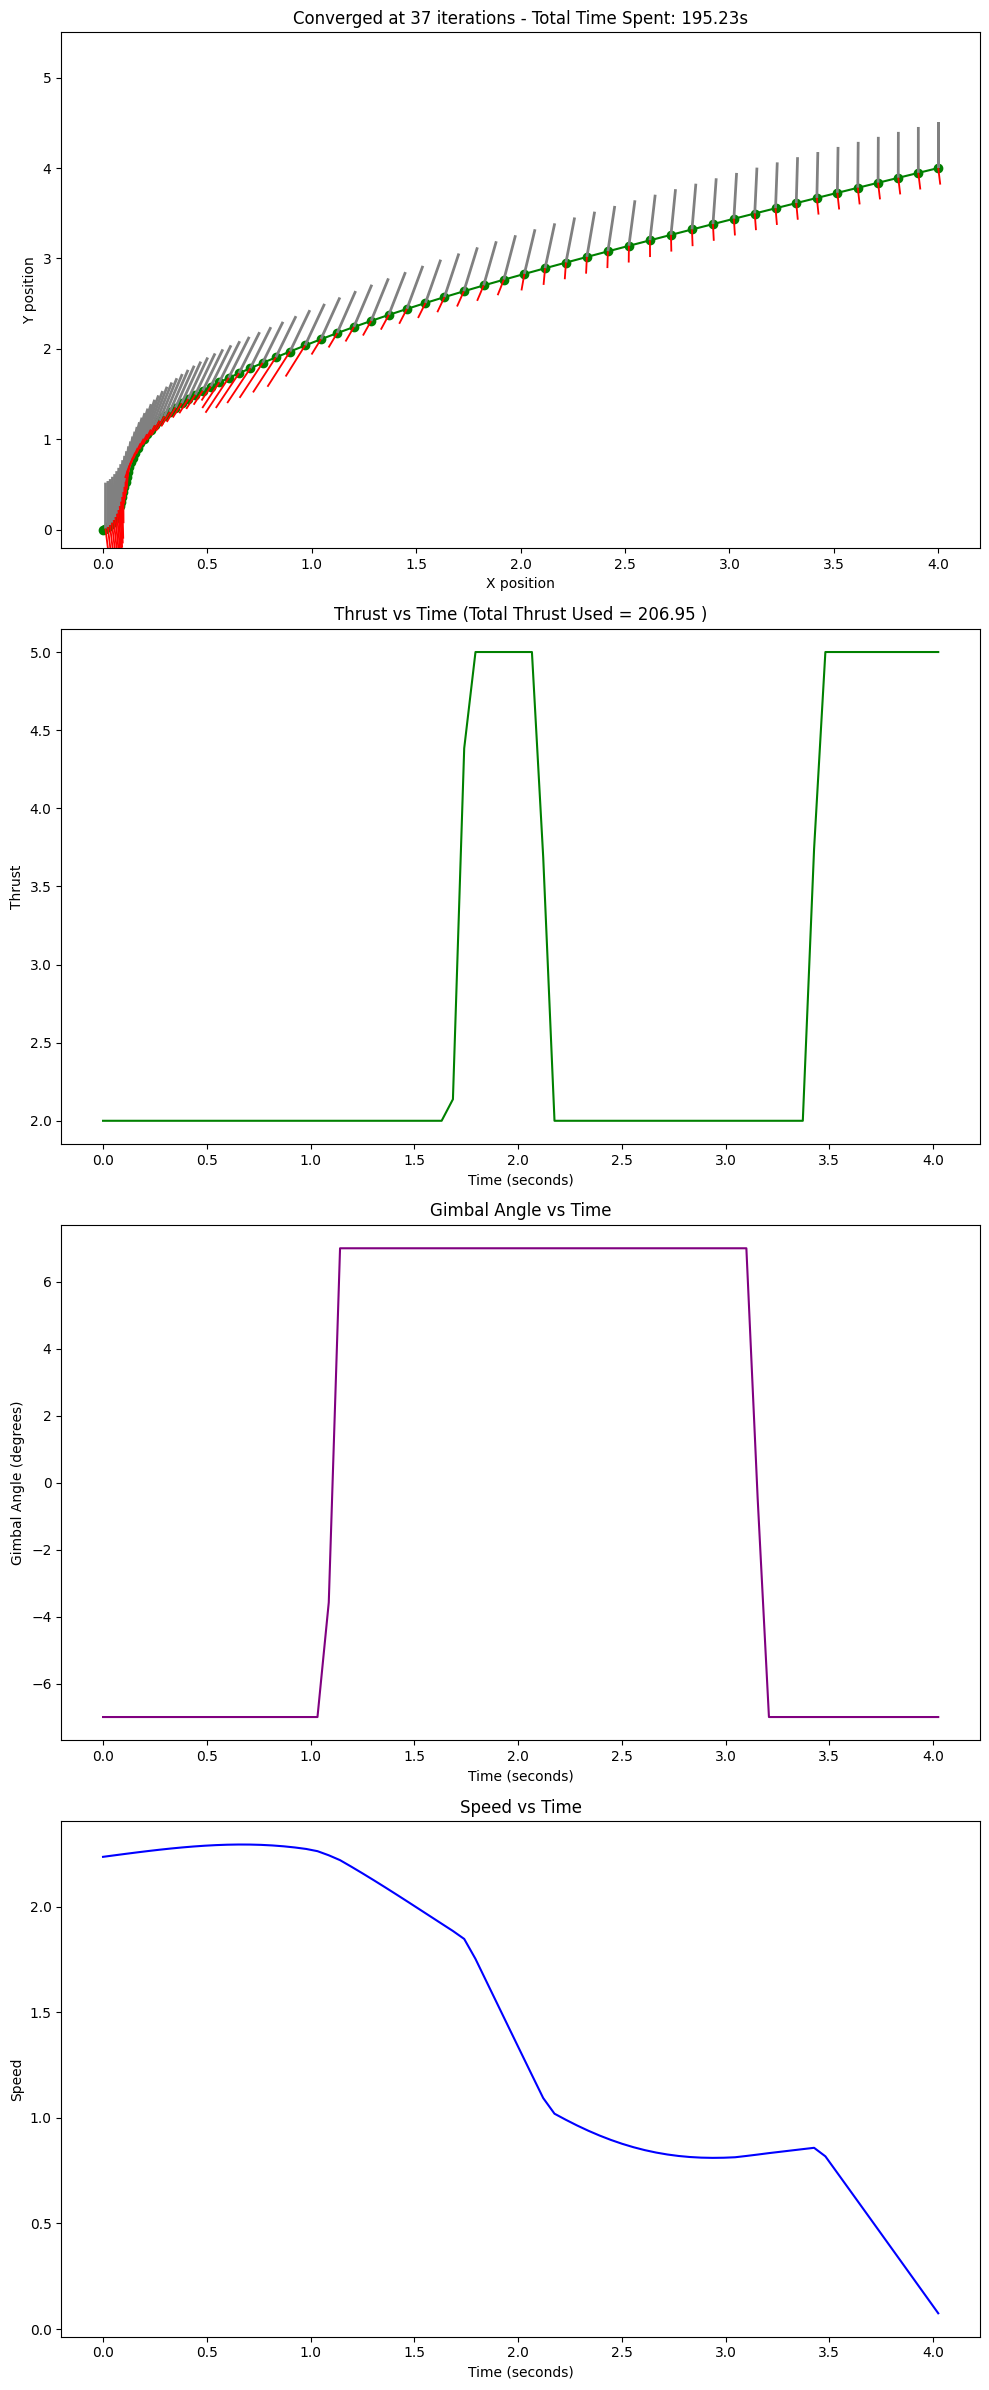

Total thrust used in all time steps: 206.95 


In [ ]:
import numpy as np
import jax.numpy as jnp
import scipy.optimize
import matplotlib.pyplot as plt
from time import time

# Define constants related to the rocket's movement
x_dim = 6  # Number of state variables: [horizontal position, vertical position, horizontal speed, vertical speed, angle, angular speed]
u_dim = 2  # Number of control variables: [gimbal angle, thrust]
g = 1   # Gravity in meters per second squared
m = 2      # Mass of the rocket in kilograms
I = 0.01   # Moment of inertia in kilogram meter squared
r_TB = 0.01 # Distance from the center of mass to the thrust point
alphamass=0.1 #mass depletion rate

# Set limits on the control variables
T_max = 5   # Maximum thrust
T_min = T_max * 0.4  # Minimum thrust
max_gimbal = np.deg2rad(7)  # Maximum gimbal angle in radians

# Set limits on the state variables
t_max = np.deg2rad(60)  # Maximum angle in radians
w_max = np.deg2rad(60)  # Maximum angular speed in radians per second


# Define the final time desired
final_time_desired = 4  # seconds

K=75; # Number of trajectory points
t0_tm = time()

#Calculating mass depletion
def mass_depletion_rate(T_B):
    global alphamass
    return -alphamass * np.linalg.norm(T_B)


# Define the rocket's movement equations
def ode(state, control):
    rx, ry, vx, vy, theta, omega = state
    gimbal, thrust = control
    return np.array([
        vx,
        vy,
        np.sin(theta + gimbal) * thrust / m,
        (np.cos(theta + gimbal) * thrust - m * g) / m,
        omega,
        (-np.sin(gimbal) * thrust * r_TB) / I
    ])

# Implement the Runge-Kutta method for more accurate numerical integration
def rk4(func, y0, dt, control):
    h = dt
    k1 = h * func(y0, control)
    k2 = h * func(y0 + 0.5 * k1, control)
    k3 = h * func(y0 + 0.5 * k2, control)
    k4 = h * func(y0 + k3, control)
    return y0 + (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Define how the rocket's state changes with time using the Runge-Kutta method, discretize
def discrete_step(state, control, dt):
    return rk4(ode, state, dt, control)

# Optimize the rocket's path to land it smoothly
def optimize_nominal_trajectory(N=75, final_time_desired=final_time_desired, return_optimize_result=False):
    x_0 = np.array([4., 4., -2., -1., 0., 0.])  # Initial state
    x_f = np.array([0., 0., 0., 0., 0., 0.])  # Final state

    Q = np.eye(x_dim)  # State cost matrix
    R = np.eye(u_dim)  # Control cost matrix
    Q_final = 100 * np.eye(x_dim)  # Final state cost matrix

    def pack_decision_variables(final_time, states, controls):
        return np.concatenate([[final_time], states.ravel(), controls.ravel()])

    def unpack_decision_variables(z):
        final_time = z[0]
        states = z[1:1 + (N + 1) * x_dim].reshape(N + 1, x_dim)
        controls = z[-N * u_dim:].reshape(N, u_dim)
        return final_time, states, controls

    def cost(z):
        final_time, states, controls = unpack_decision_variables(z)
        dt = final_time / N #step size

        control_cost = sum(controls[k].T @ R @ controls[k] for k in range(N))
        return control_cost

    z_guess = pack_decision_variables(
        final_time_desired,
        x_0 + np.linspace(0, 1, N + 1)[:, np.newaxis] * (x_f - x_0),
        np.vstack((np.zeros(N), np.full(N, (T_max + T_min) / 2))).T
    )

    lower_bounds_states = np.tile([-np.inf, -np.inf, -np.inf, -np.inf, -t_max, -w_max], (N + 1, 1)).ravel()
    upper_bounds_states = np.tile([np.inf, np.inf, np.inf, np.inf, t_max, w_max], (N + 1, 1)).ravel()

    lower_bounds_controls = np.tile([-max_gimbal, T_min], (N, 1)).ravel()
    upper_bounds_controls = np.tile([max_gimbal, T_max], (N, 1)).ravel()

    lower_bounds = np.concatenate([[0], lower_bounds_states, lower_bounds_controls])
    upper_bounds = np.concatenate([[np.inf], upper_bounds_states, upper_bounds_controls])

    bounds = scipy.optimize.Bounds(lower_bounds, upper_bounds)

    def equality_constraints(z):
        final_time, states, controls = unpack_decision_variables(z)
        dt = final_time / N
        constraint_list = [states[i + 1] - discrete_step(states[i], controls[i], dt) for i in range(N)]
        constraint_list.append(states[0] - x_0)  # Initial state constraint
        constraint_list.append(states[-1] - x_f)  # Final state constraint
        return np.concatenate(constraint_list)


    result = scipy.optimize.minimize(cost,
                                 z_guess,
                                 bounds=bounds,
                                 constraints=[{"type": "eq", "fun": equality_constraints}],
                                 options={'disp': True, 'tol': 1e-10, 'ftol': 1e-10})  # Enable verbose output, Adjust tolerance settings


    final_time, states, controls = unpack_decision_variables(result.x)

    # Print the final state
    print("Final State:")
    print(states[-1])

    total_time = time() - t0_tm

    if return_optimize_result:
        return result, total_time
    return (final_time, states, controls), total_time, result.nit  # Return number of iterations



def my_plot(fig, states, controls, final_time, total_time, nit, total_thrust):
    attitude_scale = 20
    thrust_scale = 110

    ax1 = fig.add_subplot(411)
    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)

    N = states.shape[0] - 1
    time_in_sec = np.linspace(0, final_time, N)

    # Position plot
    ax1.set_xlabel('X position')
    ax1.set_ylabel('Y position')
    ax1.plot(states[:, 0], states[:, 1], color='green', zorder=0)
    ax1.scatter(states[:, 0], states[:, 1], color='green', zorder=1)  # Adding dots at each iteration point
    rx, ry = states[:-1, 0], states[:-1, 1]
    dx, dy = np.sin(states[:-1, 4]), np.cos(states[:-1, 4])
    Fx, Fy = -np.sin(states[:-1, 4] + controls[:, 0]) * controls[:, 1], -np.cos(states[:-1, 4] + controls[:, 0]) * controls[:, 1]
    ax1.quiver(rx, ry, dx, dy, color='grey', width=0.003, scale=attitude_scale, headwidth=1, headlength=0)
    ax1.quiver(rx, ry, Fx, Fy, color='red', width=0.002, scale=thrust_scale, headwidth=1, headlength=0)
    ax1.set_title(f"Converged at {nit} iterations - Total Time Spent: {total_time:.2f}s")
    ax1.set_ylim([None, np.max(ry) + 1.5])

    # Thrust plot
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Thrust')
    ax2.plot(time_in_sec, controls[:, 1], color='green')
    ax2.set_title(f"Thrust vs Time (Total Thrust Used = {total_thrust:.2f} )")

    # Gimbal angle plot
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Gimbal Angle (degrees)')
    gimbal_angles_deg = np.rad2deg(controls[:, 0])
    ax3.plot(time_in_sec, gimbal_angles_deg, color='purple')
    ax3.set_title("Gimbal Angle vs Time")

    # Speed plot
    speed = np.sqrt(states[:-1, 2]**2 + states[:-1, 3]**2)
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Speed')
    ax4.plot(time_in_sec, speed, color='blue')
    ax4.set_title("Speed vs Time")

    fig.tight_layout()

def plot_trajectory(states, controls, final_time, total_time, nit, total_thrust):
    fig = plt.figure(figsize=(10, 24))
    my_plot(fig, states, controls, final_time, total_time, nit, total_thrust)
    plt.show()

# Solving problem
(final_time, nominal_states, nominal_controls), total_time, nit = optimize_nominal_trajectory(final_time_desired=final_time_desired)

# Calculate the total thrust used
total_thrust = np.sum(nominal_controls[:, 1])

# Plot
plot_trajectory(nominal_states, nominal_controls, final_time, total_time, nit, total_thrust)

print(f"Total thrust used in all time steps: {total_thrust:.2f} ")
